In [2]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

In [3]:
file_Hg_calib = 'CCD/Hg_calibration_1.txt'

Hg_cal = pd.read_csv(file_Hg_calib, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',')
# print(df['Channel'])

<ipython-input-3-14286bedf3a8>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  Hg_cal = pd.read_csv(file_Hg_calib, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',')


In [19]:
def lorentz(x, A, w0, gamma):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2)


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma)) + C

[2.75338326e+04 4.35413097e+02 1.21633278e-01 2.41766722e+03] [1.19747177e+03 1.43851488e-02 1.43101813e-02 8.86744342e+02]
[ 9.04077146e+04  5.45825849e+02  2.72321122e-01 -2.56502266e+04] [1.47411478e+04 1.33901800e-02 8.23035654e-02 1.57060727e+04]
[ 1.59907848e+04  5.76706504e+02  1.08681270e-01 -1.68277919e+03] [6.92763682e+02 3.85779547e-03 1.02878220e-02 7.55603777e+02]


[ 1.58508401e+04  5.78813581e+02  1.03740745e-01 -1.46356251e+03] [6.06614212e+02 3.99389152e-03 8.96688442e-03 6.60566544e+02]


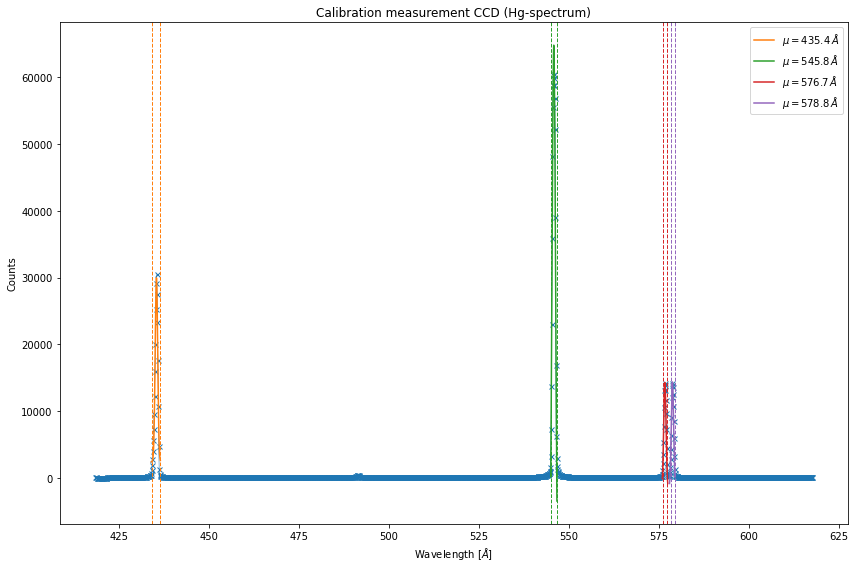

In [70]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(Hg_cal['Channel'], Hg_cal['Counts'], marker = 'x', lw=0.5, ms = 5)
coefficients = np.zeros((4, 4))
covariance = np.zeros((4, 4, 4))

a = [[133, 152], [1185, 1204], [1530, 1545], [1555, 1570]]
p0s = [[30000, 435, 1, 0], [60000, 546, 1, 0], [15000, 577, 1, 0], [15000, 579, 1, 0]]
xaxis = [np.linspace(434, 436.5 ,1001), np.linspace(545, 546.7, 1001), np.linspace(576,577.5,1001), np.linspace(578, 579.5, 1001)]
colors = ['C1', 'C2', 'C3', 'C4']
for i in range(4):
    params, cov = sc.curve_fit(gauss, Hg_cal['Channel'][a[i][0]:a[i][1]], Hg_cal['Counts'][a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i] = params
    covariance[i] = cov
    print(params, np.sqrt(np.diag(cov)))
    ax.axvline(Hg_cal['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
    ax.axvline(Hg_cal['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i], label = r'$\mu = {:.1f} \,$nm'.format(params[1]))

ax.set_xlabel(r'Wavelength [nm]')
ax.set_ylabel(r'Counts')
ax.set_title(r'Calibration measurement CCD (Hg-spectrum)')
ax.legend()
# ax.set_xlim([430, 440])  # show the first peak
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([575, 580])
plt.tight_layout()
plt.show()

In [80]:
Hg_Nist = [435.8328, 546.0735, 576.9598, 579.0663]
for i in range(4):
    print('Fit:', coefficients[i,1], r'+-', np.sqrt(covariance[i,1,1]))
    print('Nist', Hg_Nist[i])
print('\n Our CCD is slightly (approx 0.2nm) shifted down.')

Fit: 435.41309729591734 +- 0.014385148755535395
Nist 435.8328
Fit: 545.8258491117172 +- 0.013390180001561345
Nist 546.0735
Fit: 576.7065044754747 +- 0.0038577954665836626
Nist 576.9598
Fit: 578.8135808545674 +- 0.003993891521947161
Nist 579.0663

 Our CCD is slightly (approx 0.2nm) shifted down.
